In [2]:
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt 

import lifetimes
from lifetimes.utils import *
from lifetimes import BetaGeoFitter
from lifetimes import BetaGeoBetaBinomFitter
from lifetimes.plotting import plot_period_transactions
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from lifetimes.plotting import plot_expected_repeat_purchases
from lifetimes.utils import summary_data_from_transaction_data



## Data Exploration

In [4]:
raw_login_data.head(5)

,cust,date
0,2,2020-08-14
1,3,2020-06-15
2,15,2020-10-06
3,20,2020-08-22
4,35,2020-08-11


In [5]:
raw_login_data.dtypes

cust     int64
date    object
dtype: object

In [6]:
#convert date from str to datetime
raw_login_data['date'] = pd.to_datetime(raw_login_data['date'], format='%Y-%m-%d')

In [7]:
raw_login_data.shape

(100000, 2)

In [8]:
raw_login_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   cust    100000 non-null  int64         
 1   date    100000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.5 MB


In [9]:
raw_login_data.describe(datetime_is_numeric=True)

,cust,date
count,100000.000000,100000
mean,138642.347440,2020-08-16 17:06:11.232000
min,2.000000,2020-04-01 00:00:00
25%,69287.750000,2020-07-04 00:00:00
50%,138106.000000,2020-08-23 00:00:00
75%,207368.750000,2020-10-03 00:00:00
max,277320.000000,2020-11-12 00:00:00
std,79793.167168,NaN


In [10]:
#number of customers available
raw_login_data['cust'].nunique()

49261

## Data Enrichment

In [11]:
#python lifetimes function converting the login dates into RFT table
rft_df = summary_data_from_transaction_data(raw_login_data, 'cust', 'date')
rft_df.head()

,frequency,recency,T
cust,,,
2,0.0,0.0,90.0
3,0.0,0.0,150.0
15,0.0,0.0,37.0
20,0.0,0.0,82.0
35,0.0,0.0,93.0


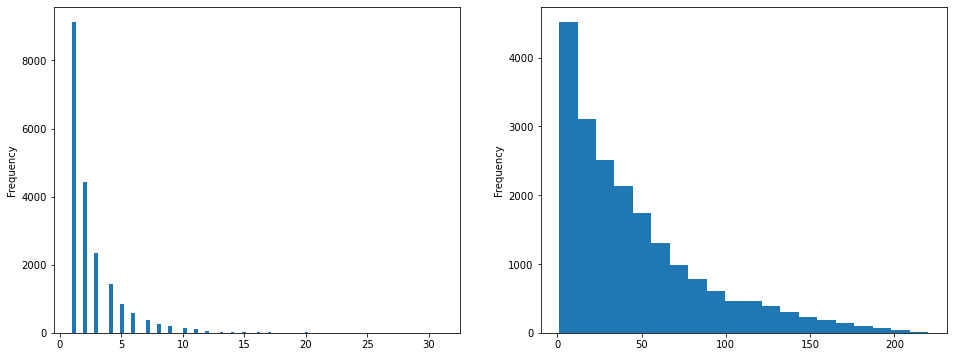

FREQUENCY:
count    20048.000000
mean         2.530876
std          2.369588
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         31.000000
Name: frequency, dtype: float64

RECENCY:
count    20048.000000
mean        45.241919
std         41.874410
min          1.000000
25%         13.000000
50%         33.000000
75%         64.000000
max        220.000000
Name: recency, dtype: float64


In [12]:
fig, ax = plt.subplots(1,2,figsize=(16,6));

rft_df[rft_df['frequency'] > 0]['frequency'].plot(kind='hist', bins=100,ax=ax[0]) #subplot 1
#ax[0].set_xlim(0, 200)
rft_df[rft_df['recency'] > 0]['recency'].plot(kind='hist', bins=20, ax=ax[1]) #subplot 2
#ax[1].set_xlim(0, 600)
plt.show()
print('FREQUENCY:')
print(rft_df[rft_df['frequency'] > 0]['frequency'].describe())
print('')
print('RECENCY:')
print(rft_df[rft_df['frequency'] > 0]['recency'].describe())


In [13]:
#TODO: remove customers with no pattern (no repeated login)

## Model Fitting:  

#### BG/NBD model

In [14]:
bgf = BetaGeoFitter(penalizer_coef=0.0)

In [15]:
bgf.fit(rft_df['frequency'], rft_df['recency'], rft_df['T'])

<lifetimes.BetaGeoFitter: fitted with 49261 subjects, a: 1.80, alpha: 11.82, b: 4.67, r: 0.28>

Parameter Interpretation:
* <b>p (=probability of our customer to become inactive)</b>  follows a <b>Beta distribution</b> with <b>a = 1.80</b> and <b>b = 4.67</b> <br></br>
* <b>alpha</b> and <b>r</b> are for the <b>Gamma distribution</b> (=heterogeneity in login rates among customers)

#### Assessing model fit (all customers; daily logins)
We have now predicted and visualized our customers’ behaviour; But how accurate is the model? 
To assess the model, first  compare our data to artificial data simulated with our fitted model’s parameters.

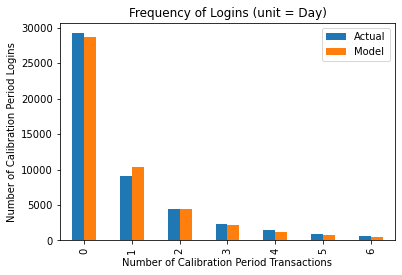

In [16]:
plot_period_transactions(bgf)
plt.title('Frequency of Logins (unit = Day)')
plt.ylabel('Number of Calibration Period Logins')
plt.ylabel('Number of Calibration Period Logins')
plt.show()



We plot the expected number of customers that are going to repeat purchase 0, 1, 2, 3 ... 6 times in the future. For each number of repeat logins (x-axis), we plot both what the model predicted and what the actual numbers were. As we can see, little to no errors in the fit for 2 repeated logins and more, how ever the error is bigger for 0 to 2 logins

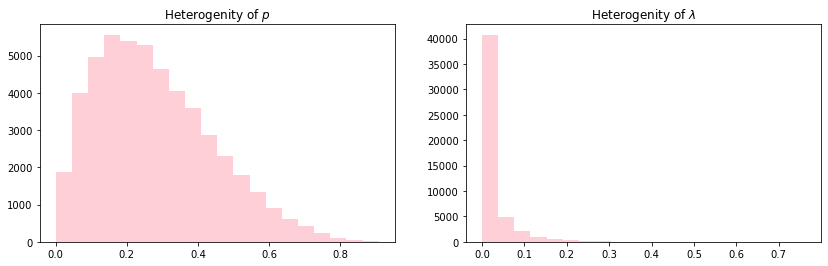

In [17]:
# Plot
from scipy.stats import beta, gamma
gbd = beta.rvs(bgf.params_['a'], bgf.params_['b'], size = 50000)
ggd = gamma.rvs(bgf.params_['r'], scale=1./bgf.params_['alpha'], size = 50000)
plt.figure(figsize=(14,4))
plt.subplot(121)
plt.title('Heterogenity of $p$')
temp = plt.hist(gbd, 20, facecolor='pink', alpha=0.75)
plt.subplot(122) 
plt.title('Heterogenity of $\lambda$')
temp = plt.hist(ggd, 20, facecolor='pink', alpha=0.75)

For what we see, the model distribution deviates a bit from the real data, and do moderately well. It seems to underestimate customers that will not login again and overestimate customers that will login again after 1/2/3 logins.

#### Visualizing the Model Frequency/Recency Matrix (all customers; daily logins)

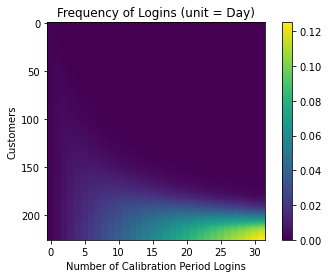

In [18]:
fig, ax = plt.subplots(figsize=(6,4));
ax=plot_frequency_recency_matrix(bgf, title='Frequency of Logins (unit = Day)',
                         xlabel='Number of Calibration Period Logins', ylabel='Customers')
plt.show()

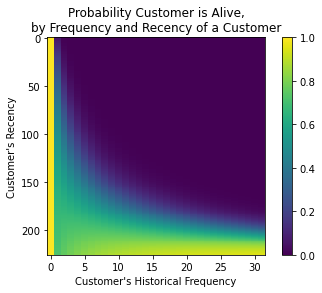

In [19]:
fig, ax = plt.subplots(figsize=(6,4));

ax = plot_probability_alive_matrix(bgf)
plt.show()

In [20]:
#TODO: describe the graphs

#### Ranking customers from best to worst

In [21]:
#ranking customers from best to worst
t=1
rft_df['predicted_login'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, rft_df['frequency'], rft_df['recency'], rft_df['T'])
rft_df.sort_values(by='predicted_login').tail(10)

,frequency,recency,T,predicted_login
cust,,,,
183208,6.0,29.0,31.0,0.115705
10452,16.0,91.0,98.0,0.116191
205420,16.0,113.0,114.0,0.116504
253280,11.0,65.0,67.0,0.121922
216030,13.0,83.0,84.0,0.122403
110313,11.0,61.0,64.0,0.123572
66471,21.0,143.0,144.0,0.125405
43850,31.0,212.0,214.0,0.129162
5830,16.0,94.0,97.0,0.129877


our 6 best customers:

In [22]:
#our 6 best customers:
t = 31*3
rft_df['predicted_login'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, rft_df['frequency'], rft_df['recency'], rft_df['T'])
best_projected_cust = rft_df.sort_values('predicted_login').tail(6)
rft_df.sort_values('predicted_login').tail(6)

,frequency,recency,T,predicted_login
cust,,,,
183041,23.0,186.0,189.0,7.343486
39858,25.0,188.0,193.0,7.679897
5830,16.0,94.0,97.0,7.696409
116467,22.0,164.0,166.0,7.743732
66471,21.0,143.0,144.0,8.197889
43850,31.0,212.0,214.0,9.158311


#### More model fitting (all customers; daily logins)
* A second method to evaluate the model is to split the dataset into a calibration period and a holdout dataset. This is very important as we want to test how our model performs on data not yet seen (i.e. cross-validation in machine learning)


In [23]:
summary_cal_holdout = calibration_and_holdout_data(raw_login_data, 'cust', 'date',
                                        calibration_period_end=dt.datetime(2020,10,4).date(),
                                        observation_period_end=dt.datetime(2020,11,1).date(),
                                                  freq='D')
                                                  
summary_cal_holdout.head()


,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
cust,,,,,
2,0.0,0.0,51.0,0.0,28.0
3,0.0,0.0,111.0,0.0,28.0
20,0.0,0.0,43.0,0.0,28.0
35,0.0,0.0,54.0,0.0,28.0
38,0.0,0.0,38.0,0.0,28.0


In [24]:
#fit the calibration output df
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])


<lifetimes.BetaGeoFitter: fitted with 39239 subjects, a: 2.15, alpha: 12.69, b: 6.15, r: 0.30>

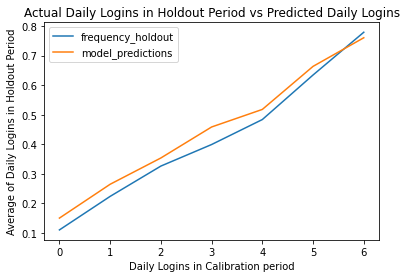

In [25]:
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)
plt.title('Actual Daily Logins in Holdout Period vs Predicted Daily Logins')
plt.ylabel('Average of Daily Logins in Holdout Period')
plt.xlabel('Daily Logins in Calibration period')
plt.show()

Observations:
    
* The model is predicting relatively well, it tends to overestimate customers expected to login for 3 times after the first login, and slightly underestimates customers with 6 logins